In [1]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf
tfds.disable_progress_bar()
import collections
import pathlib
import re
import string
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras import utils
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
import matplotlib.pyplot as plt
import tensorflow_text as tf_text
from tensorflow import keras

In [2]:
tfds.disable_progress_bar()


def plot_graphs(history, metric):   #define a function to plot the history graph with accuracy and loss
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])

In [3]:
#batch_size = 32
seed = 42  #set seed

train_dataset = preprocessing.text_dataset_from_directory( #separate the dataset to training dataset and test dataset
    'bbc', 
#    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

Found 2225 files belonging to 5 classes.
Using 1780 files for training.


In [4]:
test_dataset = preprocessing.text_dataset_from_directory(
    'bbc',
#    batch_size=batch_size,
    validation_split=.2,
    subset='validation',
    seed=seed)

Found 2225 files belonging to 5 classes.
Using 445 files for validation.


In [5]:
VOCAB_SIZE=5000  #set the size of the vocabulary lab 
#The raw text loaded by tfds needs to be processed before it can be used in a model. 
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(  # experimental preprocessing
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text)) #Create the layer, and pass the dataset's text to the layer's .adapt method

In [6]:
vocab = np.array(encoder.get_vocabulary())


In [7]:
model = tf.keras.Sequential([  #build the sequential
    encoder,  #first encoder layer defined above
    tf.keras.layers.Embedding( # with 64 dim output
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)), #LSTM 64 dims
    tf.keras.layers.Dense(64, activation='relu'), # 64 cells with relu activation function
    tf.keras.layers.Dense(5, activation='softmax') # 5 dim output with softmax activation function
])

In [8]:
model.compile(loss='sparse_categorical_crossentropy', # loss function 
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), #optimizer with learning rate .001
              metrics=['accuracy']) # metrics set to be accuracy

In [9]:
earlystopping_cb = keras.callbacks.EarlyStopping (patience=10, restore_best_weights=True) # set callbacks

In [10]:
history = model.fit(train_dataset, epochs=50, #training process epochs=50
                    validation_data=test_dataset, 
                    validation_steps=10,
                    callbacks=earlystopping_cb) #set callbacks

Epoch 1/50
56/56 [==============================] - 53s 951ms/step - loss: 1.5598 - accuracy: 0.2820 - val_loss: 1.6199 - val_accuracy: 0.2844
Epoch 2/50
56/56 [==============================] - 51s 903ms/step - loss: 1.2594 - accuracy: 0.4899 - val_loss: 1.3655 - val_accuracy: 0.4531
Epoch 3/50
56/56 [==============================] - 49s 877ms/step - loss: 0.9766 - accuracy: 0.6264 - val_loss: 0.8626 - val_accuracy: 0.7656
Epoch 4/50
56/56 [==============================] - 50s 887ms/step - loss: 0.4692 - accuracy: 0.8539 - val_loss: 0.4323 - val_accuracy: 0.8781
Epoch 5/50
56/56 [==============================] - 50s 899ms/step - loss: 0.1201 - accuracy: 0.9753 - val_loss: 0.2681 - val_accuracy: 0.9312
Epoch 6/50
56/56 [==============================] - 50s 891ms/step - loss: 0.0383 - accuracy: 0.9910 - val_loss: 0.3691 - val_accuracy: 0.9000
Epoch 7/50
56/56 [==============================] - 45s 800ms/step - loss: 0.0185 - accuracy: 0.9955 - val_loss: 0.3471 - val_accuracy: 0.9062

In [11]:
test_loss, test_acc = model.evaluate(test_dataset) #result evaluation 

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

14/14 [==============================] - 2s 132ms/step - loss: 0.3369 - accuracy: 0.9169
Test Loss: 0.3368772268295288
Test Accuracy: 0.9168539047241211


(0.0, 1.7008122442057356)

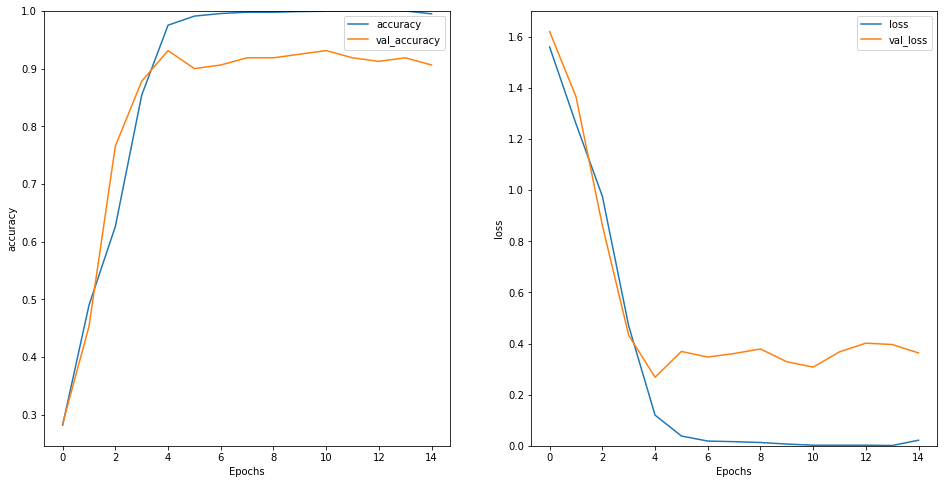

In [12]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plot_graphs(history, 'accuracy')
plt.ylim(None,1)
plt.subplot(1,2,2)
plot_graphs(history, 'loss')
plt.ylim(0,None)

In [93]:
test = list(test_dataset)
x_test = []
y_test = []
for line in range(len(test)):
    for i in test[line][0]:
        x_test.append(i)
    for j in test[line][1]:
        y_test.append(j)
y_test = np.array(y_test)

In [94]:
test_np = np.stack(list(x_test))

In [95]:
predictions = model.predict(test_np)
y_pred = np.array(tf.argmax(predictions, axis=1))

In [96]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

0.9168539325842696


In [108]:
count = 0
count_tab = []
for i,j in zip(y_test, y_pred):
    if i != j:
        count_tab.append(count)
    count +=1

In [ ]:
# business
# entertainment
# politics
# sport
# tech

In [111]:
y_test[count_tab[0]],y_pred[count_tab[0]] 
# entertainment -> tech. The text talk about the CD and market which have relationship to the tech

(1, 4)

In [110]:
test_np[count_tab[0]]

b'UK \'world\'s biggest music buyer\'\n\nUK consumers are the biggest music buyers in the world, according to new figures released on Tuesday by the British Phonographic Industry (BPI).\n\nBut global sales of recorded music were flat in 2004, with growing sales in DVD music videos offset by online and physical piracy in major markets. The UK music industry recorded an overall 3% increase in volume sales, mostly due to its robust albums market. However, world music sales declined by 1.3% to $33.6 billion (\xc2\xa317.7 billion). The UK CD albums market grew by 4.5% in 2004 with a record 174.6 million units sold. On average every Briton buys 3.2 CDs per person per year.\n\nAround 26,000 albums are released in the UK each year, making Britain second only to the US in terms of the number of releases. Overall sales were driven by new UK-signed artists such as Keane, Katie Melua and Scissor Sisters, whose debut album sold almost 1.6 million copies in the UK. "A slew of great new British artis

In [113]:
y_test[count_tab[1]],y_pred[count_tab[1]]
# tech -> entertainment. The text talk about playstation and vedio games, may lead to a entertainment subject

(4, 1)

In [114]:
test_np[count_tab[1]]

b'Half-Life 2 sweeps Bafta awards\n\nPC first person shooter Half-Life 2 has won six Bafta Awards, including best game and best online game.\n\nThe title, developed by Valve, was released last year to universal acclaim - receiving special praise for its immersive plot and physics engine. The game also won Baftas for best action adventure, best PC game, art direction and animation. Burnout 3 won three awards in the categories for racing, technical direction and best PlayStation 2 game. Grant Dean, chairman of the Bafta games awards, said at a ceremony in London on Tuesday: "The last year has been a great year for the interactive entertainment industry.\n\n"These awards reflect the enormous achievements, progress and diversity that we have seen in that time." Halo 2 won the best Xbox game category, while Prince of Persia: Warrior Within was adjudged the best GameCube title. The sports award went to Konami\'s Pro Evolution Soccer 4. Bafta said the "significant feature" of this year\'s awa

In [115]:
y_test[count_tab[2]],y_pred[count_tab[2]]
# politics -> sports. Not sure why it is wrong, may because too many names are mentioned

(2, 3)

In [116]:
test_np[count_tab[2]]

b'Galloway plea for hostage release\n\nEx-Labour MP George Galloway has appealed for the release of aid worker Margaret Hassan, kidnapped in Iraq.\n\nMrs Hassan, 59, who led Care International operations in Iraq, was abducted in Baghdad on 19 October. Mr Galloway was expelled from the Labour party because of his staunch opposition to the war on Iraq. He denied an earlier report that he planned to make a direct appeal to the kidnappers via the Al-Jazeera Arabic television channel.\n\nSpeaking in London on Saturday at the first annual delegate conference of his newly-founded party, the Respect Coalition, he said: "I have deliberately not involved myself before in any of these situations. "But this woman has been a prominent opponent of both the war and the preceding years of sanctions. "I am prepared to do anything I can to help save her life." A spokesman later said Mr Galloway had friends in common with Ms Hassan, who he described as a prominent anti-war activist, and that he was "will